In [2]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import s2fft


JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


In [3]:
def mw_alm_2_hp_alm(MW_alm, lmax):
    '''MW_alm: 2D array of shape (Lmax, 2*Lmax-1) (MW sampling, McEwen & Wiaux)
    '''
    # Initialize the 1D hp_alm array with the appropriate size
    hp_alm = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
        
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(lmax, l, abs(m))
            if m < 0:
                hp_alm[index] = (-1)**m * np.conj(MW_alm[l, lmax + m])
            else:
                hp_alm[index] = MW_alm[l, lmax + m]

    return hp_alm

def hp_alm_2_mw_alm(hp_alm, L_max):
    MW_alm = np.zeros((L_max, 2 * L_max - 1), dtype=np.complex128)

    for l in range(L_max):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(L_max - 1, l, abs(m))
            if m < 0:
                MW_alm[l, L_max + m - 1] = (-1) ** m * np.conj(hp_alm[index])
            else:
                MW_alm[l, L_max + m - 1] = hp_alm[index]

    return MW_alm

def visualize_wavelet_coefficient_map(MW_Pix_Map, title, Frequency, min=None, max=None):
    """
    Processes a wavelet coefficient map and visualizes it using HEALPix mollview.
    Parameters:
        original_70: numpy array representing the wavelet coefficient map.
    Returns:
        Displays a mollview map.
    """
    # import healpy as hp  # Make sure to import healpy
    # from s2fft import forward  # Assuming s2fft.forward is imported
    if MW_Pix_Map.shape[0] != 1:
        L_max = MW_Pix_Map.shape[0]
    else:
        L_max = MW_Pix_Map.shape[1]
    original_map_alm = s2fft.forward(MW_Pix_Map, L=L_max)
    # print("Original map alm shape:", original_map_alm.shape)
    
    original_map_hp_alm = mw_alm_2_hp_alm(original_map_alm, L_max - 1)
    original_hp_map = hp.alm2map(original_map_hp_alm, nside=(L_max - 1)//2)

    hp.mollview(
        # original_hp_map * 1e5,
        original_hp_map,
        coord=["G"],
        title=title+Frequency,
        # unit=r"$1e5$K",
        # min=min, max=max,  # Uncomment and adjust these as necessary for better visualization contrast
    )


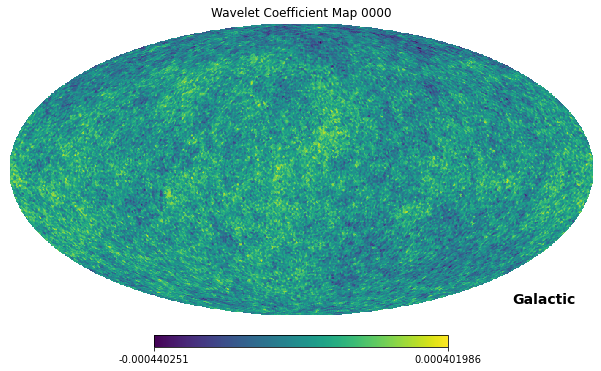

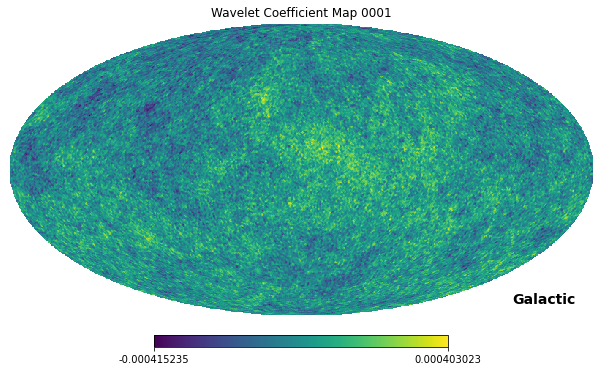

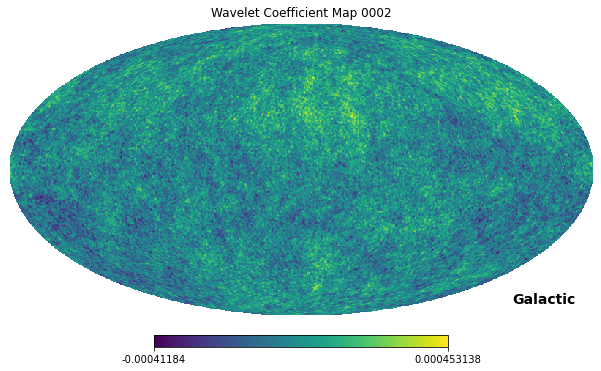

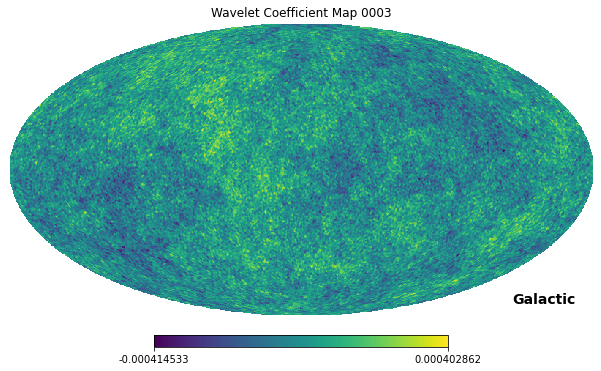

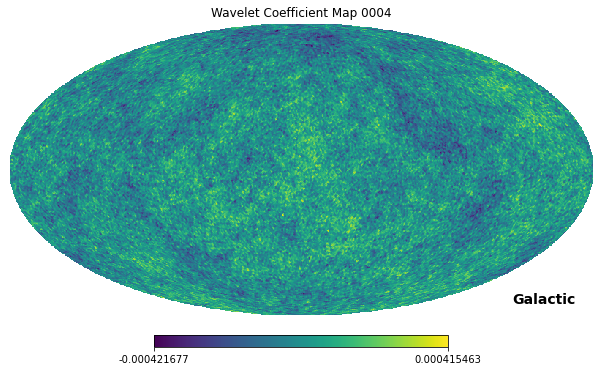

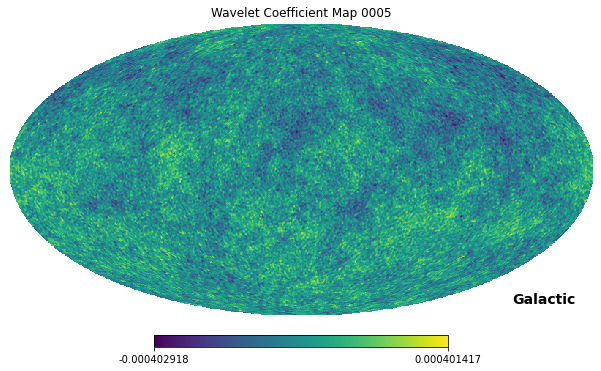

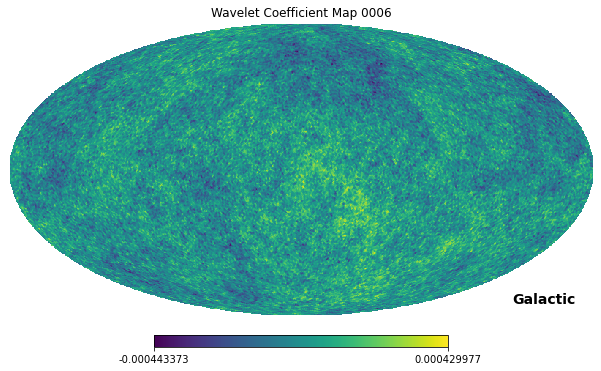

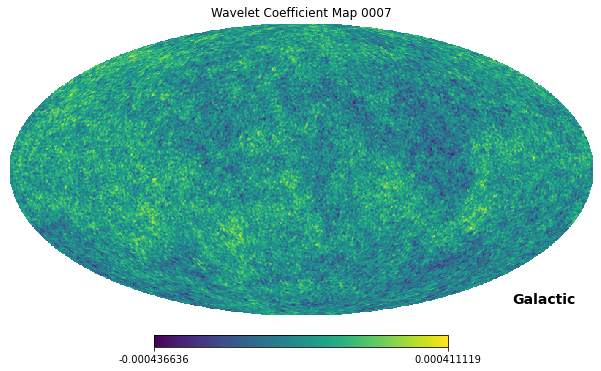

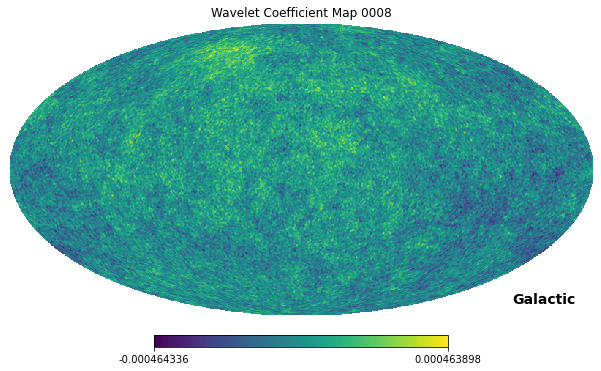

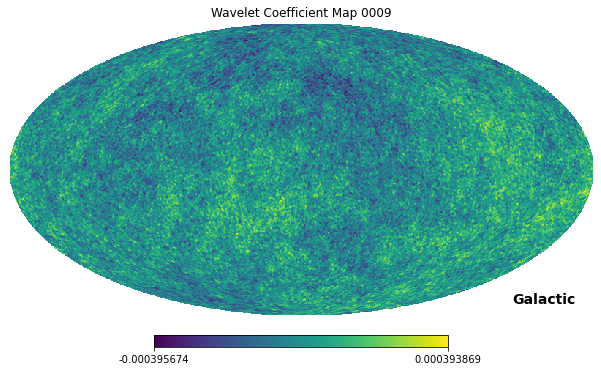

In [46]:
# for realization in range(10):
    # realization_str = str(realization).zfill(4)
    # MW_Pix_Map = np.load(f'mask_R{realization_str}.npy')

for realization in range(10):
    realization_str = str(realization).zfill(4)
    MW_Pix_Map = np.load(f'CMB_MW_Pix_Map_Mask_R{realization_str}.npy')
    visualize_wavelet_coefficient_map(MW_Pix_Map, 'CMB Map ', f'{realization_str}')
    # plt.savefig(f'../data/processed/figures/Wavelet_Coefficient_Map_{i}.png')
    # plt.show()
    # plt.close()

In [7]:
MW_Pix_Map = np.load(f'mask_R0001.npy')
MW_Pix_Map.shape

(256, 511)

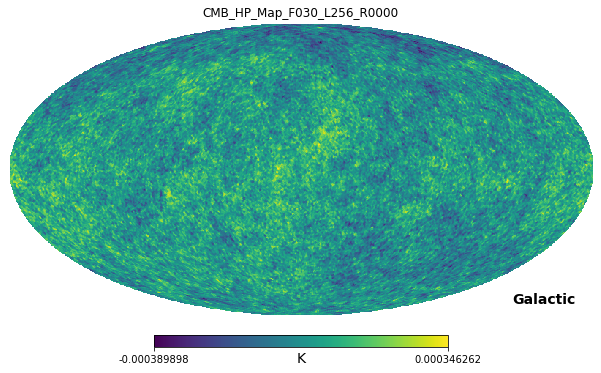

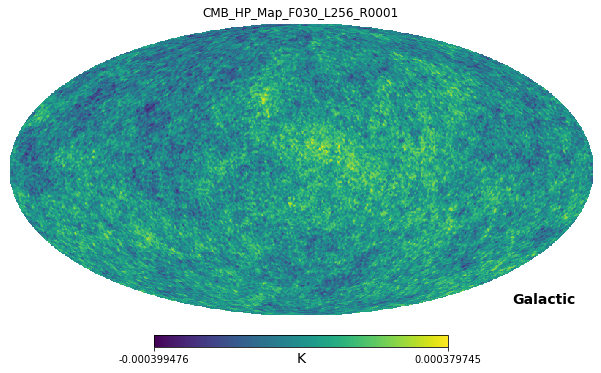

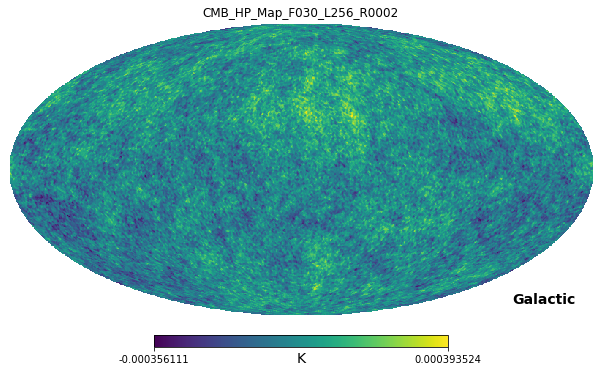

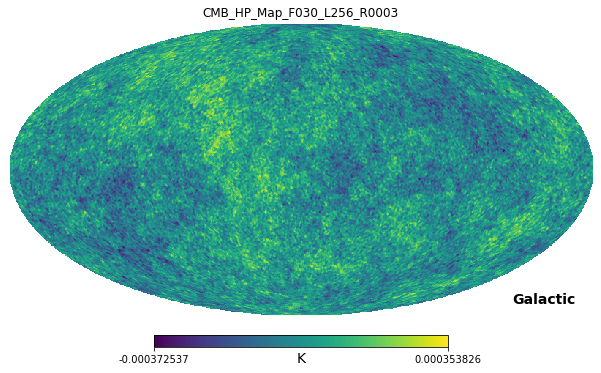

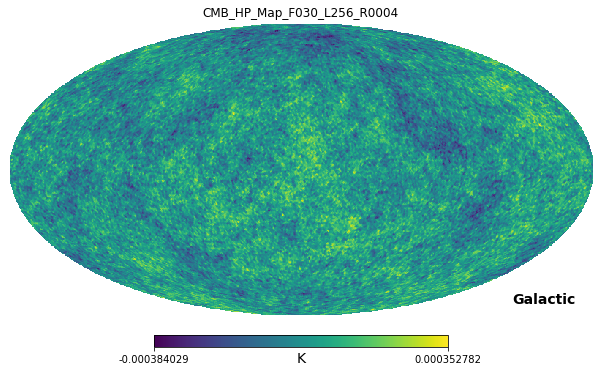

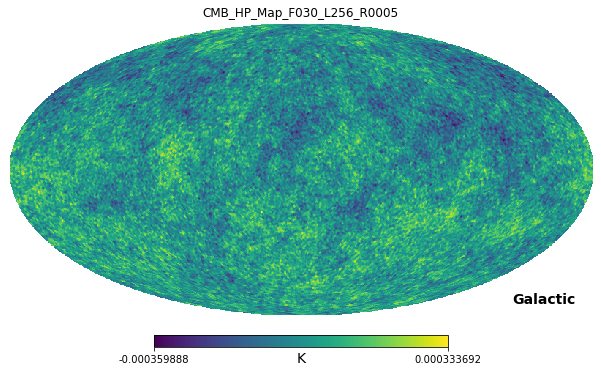

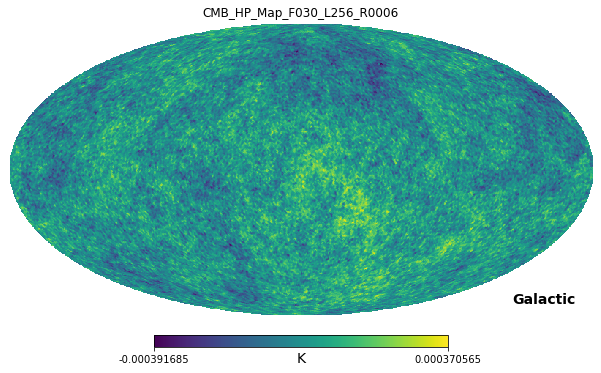

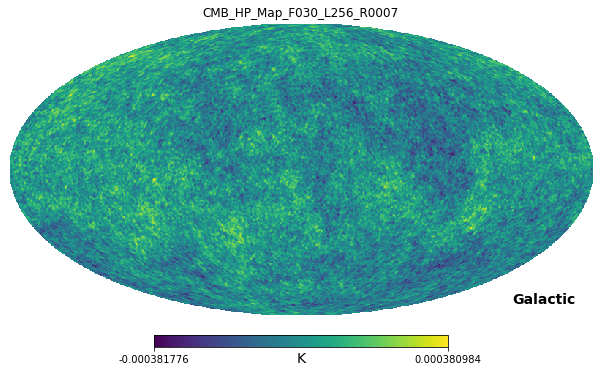

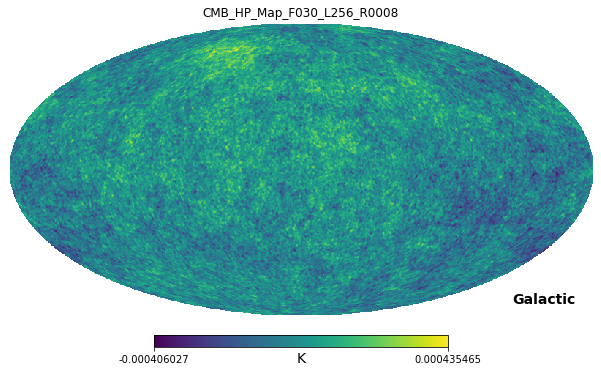

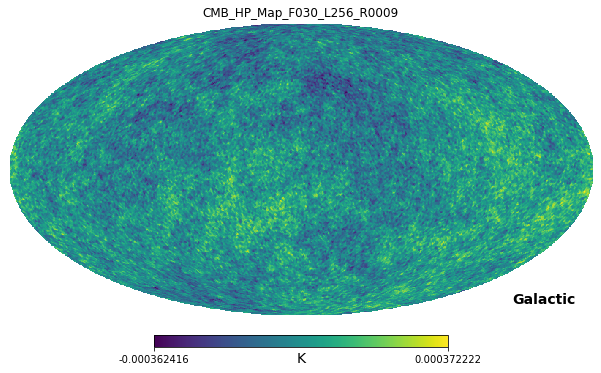

In [15]:
for realization in range(10):
    realization_str = str(realization).zfill(4)
    hp.mollview(hp.read_map(f'../../../CMB_total/CMB_HP_Map_F100_L256_R{realization_str}.fits'), coord=["G"], title=f'CMB_HP_Map_F030_L256_R{realization_str}', unit=r"K")
# /home/max/CMB_plot/code/CMB_total/CMB_HP_Map_F030_L256_R0000.fits

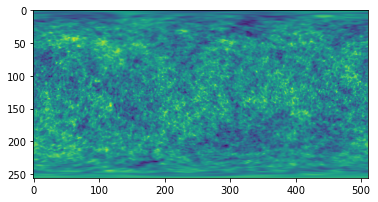

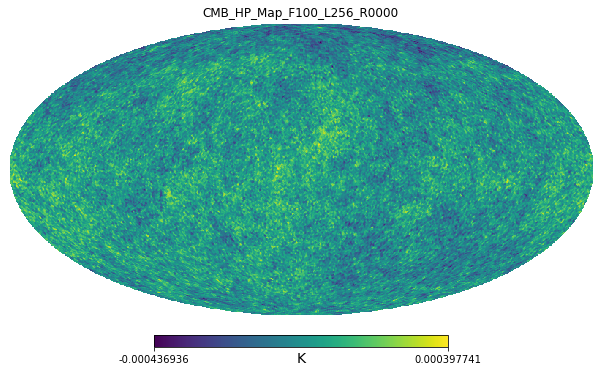

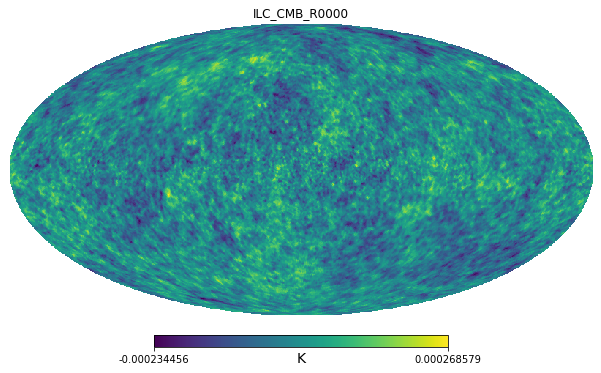

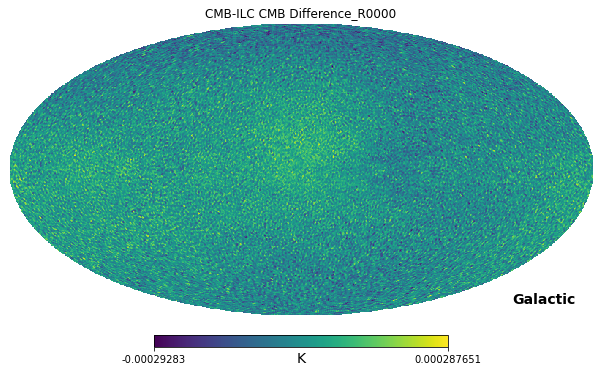

In [8]:
import matplotlib.pyplot as plt
# fig, axes = plt.subplots(figsize=(25,11))
# fig.suptitle('CMB-ILC CMB Differences for 10 Realizations', fontsize=16)
# axes.get_xaxis().set_visible(False)
# axes.get_yaxis().set_visible(False)
for realization in range(1):
    realization_str = str(realization).zfill(4)
    cmb_hp_map = hp.read_map(f'../../../CMB_total/CMB_HP_Map_F100_L256_R{realization_str}.fits',)
    cmb_hp_alm = hp.map2alm(cmb_hp_map, lmax=255,)
    cmb_MW_alm = hp_alm_2_mw_alm(cmb_hp_alm, 256)
    cmb_MW_Pix_Map = s2fft.inverse(cmb_MW_alm, L = 256)

    np.save(f'CMB_MW_Pix_Map_Mask_R{realization_str}.npy', cmb_MW_Pix_Map)
    MW_Pix_Map = np.load(f'../../../ILC/synthesized_ILC_MW_maps/ILC_MW_Map_R{realization_str}_0.npy')
    plt.imshow(np.real(MW_Pix_Map))
    ILC_cmb_hp_map = hp.alm2map(mw_alm_2_hp_alm(s2fft.forward(MW_Pix_Map,L = 256),255), nside=128)
    hp.mollview(cmb_hp_map, title=f'CMB_HP_Map_F100_L256_R{realization_str}', unit=r"K")
    hp.mollview(ILC_cmb_hp_map, title=f'ILC_CMB_R{realization_str}', unit=r"K")
    difference = cmb_hp_map - ILC_cmb_hp_map
    np.save(f'CMB_Difference_Mask_R{realization_str}.npy', difference)
    # plt.subplot(2, 5, realization + 1)
    hp.mollview(difference, coord=["G"], title=f'CMB-ILC CMB Difference_R{realization_str}', unit=r"K")
    # hp.mollview(difference, coord=["G"], title=f'CMB-ILC CMB Difference_R{realization_str}', unit=r"K", sub=(2, 5, realization + 1))

# plt.subplots_adjust(wspace=0.3, hspace=0.3)

# plt.show()